![](https://www.wsp.com/-/media/Hubs/Global/Congestion-Management/bnr-congestion.jpg)

# <span style='color:#A80808'>Goal</span>

Forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network.

# <span style='color:#A80808'>Metric</span>

Submissions are evaluated on the **mean absolute error** between predicted and actual congestion values for each time period in the test set. The congestion target has integer values from 0 to 100.

# <span style='color:#A80808'>Data</span>

**train.csv** - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.
* row_id - a unique identifier for this instance
* time - the 20-minute period in which each measurement was taken
* x - the east-west midpoint coordinate of the roadway
* y - the north-south midpoint coordinate of the roadway
* direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
* congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

**test.csv** - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-06-30.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'gray'
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr, ExtraTreesRegressor as etr
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor as lgb

import warnings
warnings.simplefilter('ignore')

# <span style='color:#A80808'>Load data</span>

In [6]:
train = pd.read_csv('Data/train.csv')
train.time = pd.to_datetime(train.time)
train['time_id'] = ( ( (train.time.dt.dayofyear-1)*24*60 + train.time.dt.hour*60 + train.time.dt.minute ) /20 ).astype(int)
train = train.set_index('row_id', drop=True)
train.head(3)

,time,x,y,direction,congestion,time_id
row_id,,,,,,
0,1991-04-01,0,0,EB,70,6480
1,1991-04-01,0,0,NB,49,6480
2,1991-04-01,0,0,SB,24,6480


In [7]:
test = pd.read_csv('Data/test.csv', index_col='row_id')
test.time = pd.to_datetime(test.time)

submission = pd.read_csv('Data/sample_submission.csv')

# <span style='color:#A80808'>Roadways</span>

There are 65 roadways that are combined by 12 locations (3x * 4y) and 8 directions (some locations have less than 8 directions).

In [8]:
train['dir_xy'] = train.direction.map({'EB':'[1,0]', 'NB':'[0,1]', 'SB':'[0,-1]', 'WB':'[-1,0]', 'NE':'[1,1]', 'SW':'[-1,-1]', 'NW':'[-1,1]', 'SE':'[1,-1]'})

In [9]:
loc_dir = train.groupby(['x','y']).dir_xy.unique().reset_index()
loc_dir['num_dir'] = loc_dir.dir_xy.apply(lambda x: len(x))
print(loc_dir)
print(f'Number of roadways: {loc_dir.num_dir.sum()}')

    x  y                                             dir_xy  num_dir
0   0  0                             [[1,0], [0,1], [0,-1]]        3
1   0  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
2   0  2                     [[1,0], [0,1], [0,-1], [-1,0]]        4
3   0  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
4   1  0     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
5   1  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
6   1  2     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
7   1  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
8   2  0                     [[1,0], [0,1], [0,-1], [-1,0]]        4
9   2  1  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
10  2  2  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
11  2  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
Number of roadways: 65


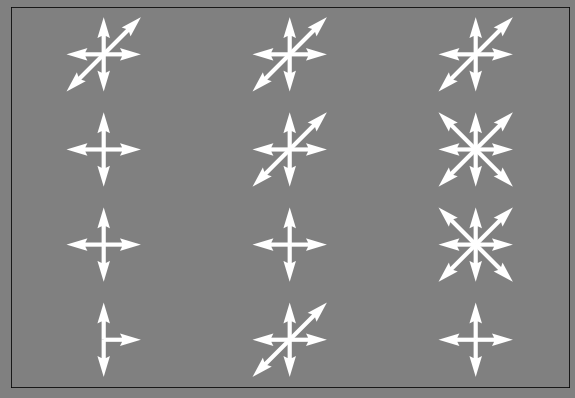

In [10]:
plt.figure(figsize=(10,7), facecolor='gray')

for idx, row in loc_dir.iterrows():
    origin = np.repeat(np.array([[row.x],[row.y]]),row.num_dir, axis=-1)
    V = np.array([eval(s) for s in row.dir_xy])
    
    plt.quiver(*origin, V[:,0], V[:,1], scale=15, color='white')
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
train = train.drop('dir_xy',axis=1)

# <span style='color:#A80808'>The time</span>

There are exactly 13059 observations for each roadway during the period from 0h 01 April to 11h40 30 September 1991. With one observation per 20 minutes, there are 13140 observation instants during this period. Hence, there are 81 missing observations per roadway that makes up to 81 x 65 = 5265 missing observations.

In [12]:
print(train.groupby(['x', 'y', 'direction']).time.count())
print(f'Total time instants within the observation period: {int(train.time_id.max() - train.time_id.min()+1)}')

x  y  direction
0  0  EB           13059
      NB           13059
      SB           13059
   1  EB           13059
      NB           13059
                   ...  
2  3  NB           13059
      NE           13059
      SB           13059
      SW           13059
      WB           13059
Name: time, Length: 65, dtype: int64
Total time instants within the observation period: 13140


The 5265 missing instants can be filled as below

In [13]:
time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])

dfs = []
for group in train.groupby(['x', 'y', 'direction']):
    dfs.append(group[1].merge(time, on='time', how= 'right'))

train_new = pd.concat(dfs, axis=0).sort_values(['time', 'x', 'y', 'direction']).reset_index()
print(f'Missing row:\n{train_new.isna().sum()}')

Missing row:
index            0
time             0
x             5265
y             5265
direction     5265
congestion    5265
time_id       5265
dtype: int64


# <span style='color:#A80808'>Target: congestion level</span>

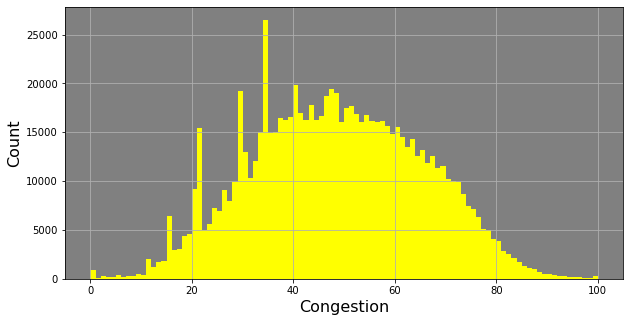

In [14]:
# Histogram
plt.figure(figsize=(10,5))
train.congestion.hist(bins=100, color='yellow')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

The abnormal columns are originated by the constant values filling the missing observations during the morning of each day. See also the daily animations in the [notebook](https://www.kaggle.com/sytuannguyen/tps-mar-2022-time-space-animation) for more details.

# <span style='color:#A80808'>Morning vs Afternoon</span>

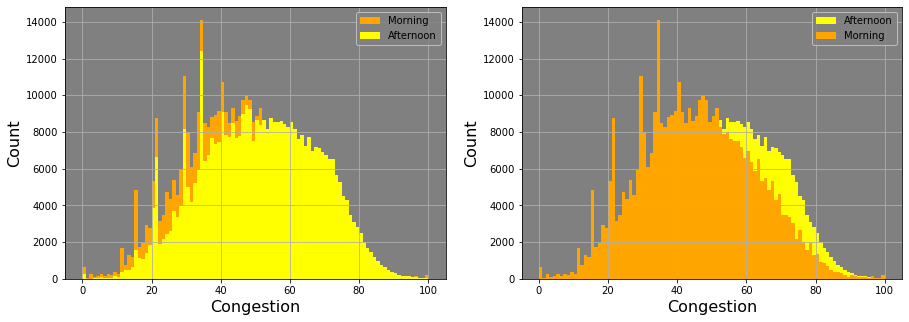

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
train[train.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.subplot(1,2,2)
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
train[train.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.show()

If we add 5 congestion units to the moning data, its distribution fits quite well with that of the afternoon

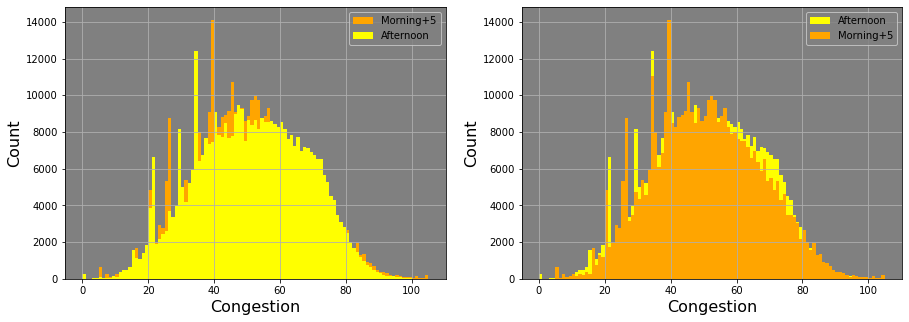

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
(train[train.time.dt.hour<12].congestion+5).hist(bins=100, color='orange', label='Morning+5')
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.subplot(1,2,2)
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
(train[train.time.dt.hour<12].congestion+5).hist(bins=100, color='orange', label='Morning+5')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.show()

# <span style='color:#A80808'>Histograms for each roadway</span>

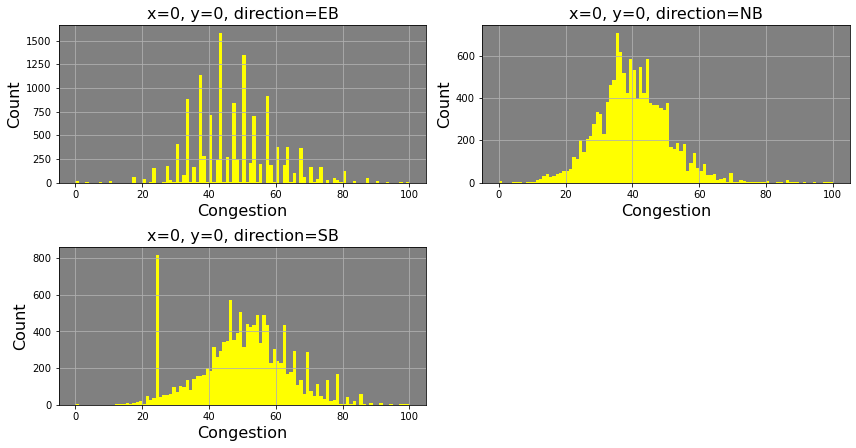

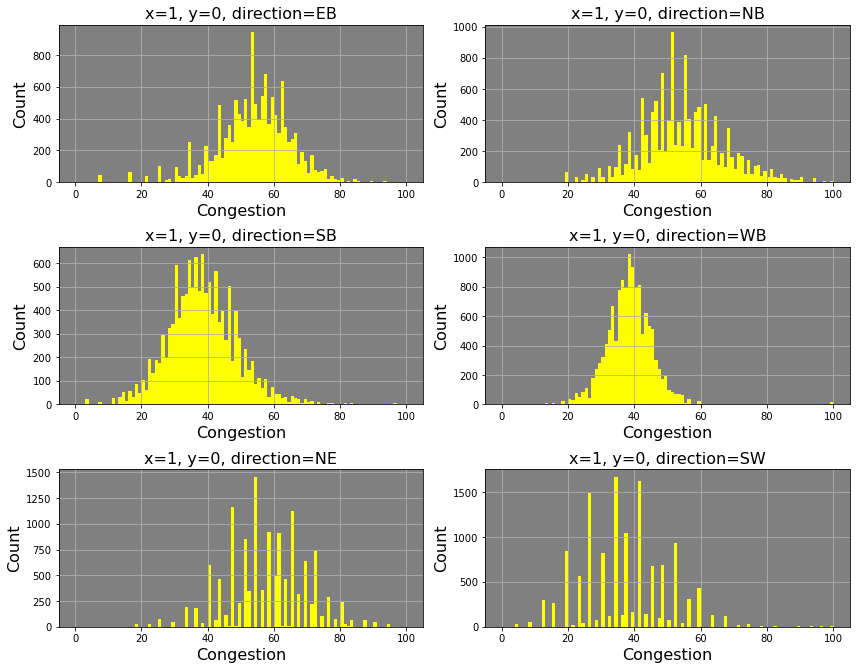

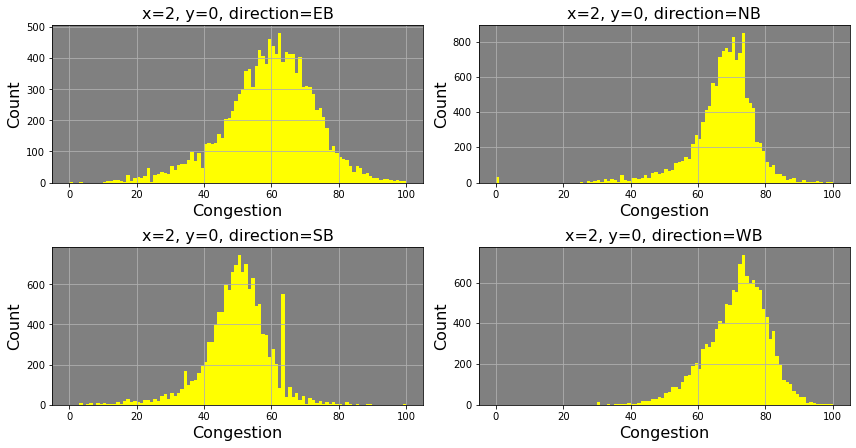

In [17]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,12))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:
                plt.subplot(4,2,idx+1)
                df.congestion.hist(bins=100, color='yellow')
                plt.title(f'x={x}, y={y}, direction={direction}', fontsize=16)
                plt.xlabel('Congestion', fontsize=16)
                plt.ylabel('Count', fontsize=16)
                plt.tight_layout()
            
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Correlation between 12 locations</span>

Some strong correlations of congestion can be observed between the locations. For example, the location x=1, y=2 and the one with x=1 and y=3 have a high correlation coefficient of 0.79.

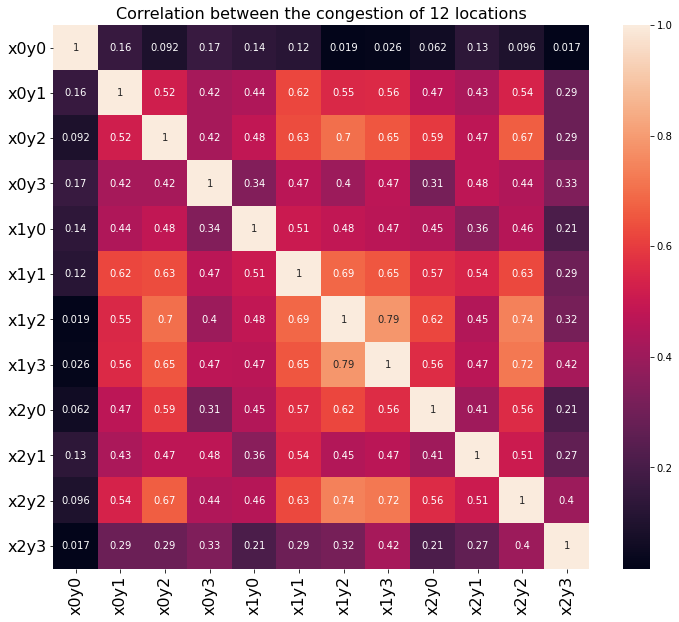

In [18]:
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.figure(figsize=(12,10))
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the congestion of 12 locations', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.show()

# <span style='color:#A80808'>Correlation between 12 locations at two consecutive instants</span>

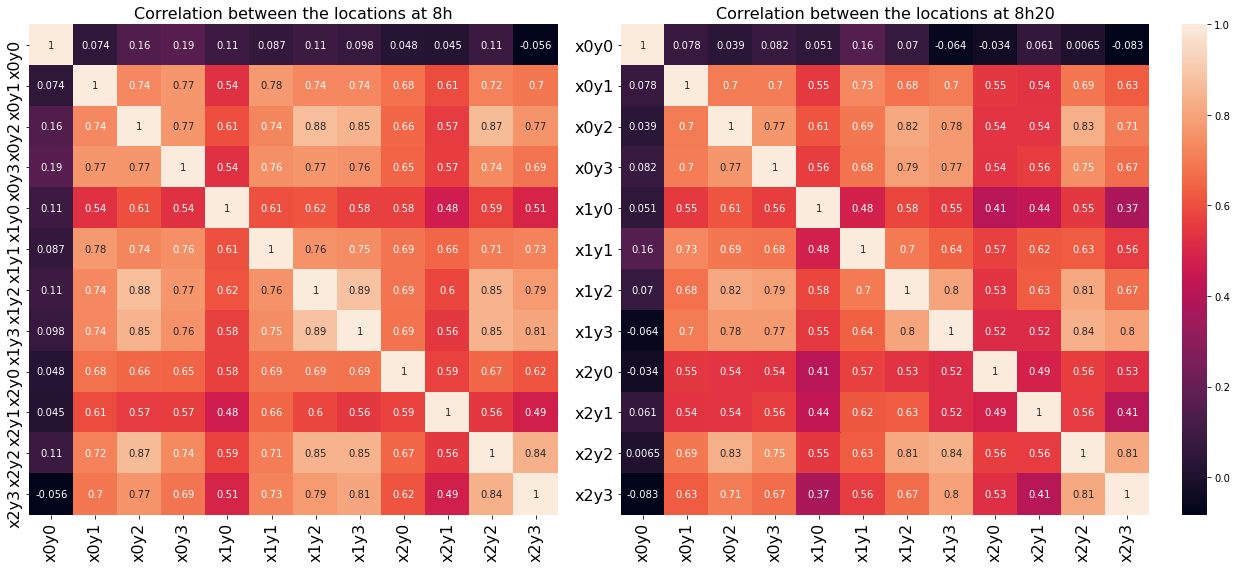

In [19]:
plt.figure(figsize=(18,8))

# At 12h
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y) & (train.time.dt.hour==8) & (train.time.dt.minute==0)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1,2,1)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=90, fontsize=16)
plt.tight_layout()

# At 12h20'
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y) & (train.time.dt.hour==8) & (train.time.dt.minute==20)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1,2,2)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h20', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()

plt.show()

# <span style='color:#A80808'>Daily correlation between the locations (x,y)=(1,2) and (1,3)</span>

These two locations seem to be highly connected during the rush hours (8am and 5pm).

In [20]:
train['daytime_id'] = ( (train.time.dt.hour*60+train.time.dt.minute) /20 ).astype(int)

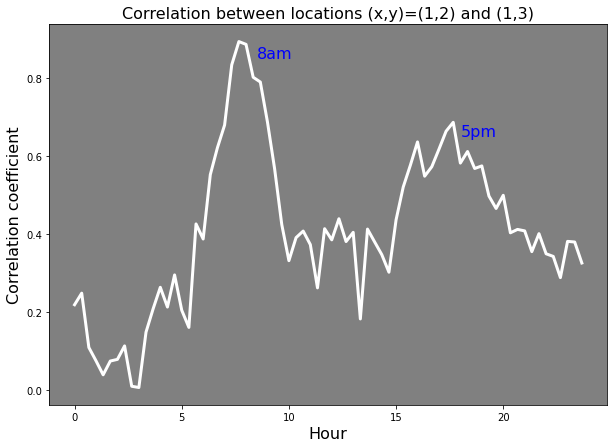

In [21]:
corrs = []
for daytime_id in train.daytime_id.unique():
    loc_12 = train[(train.x == 1) & (train.y==2) & (train.daytime_id==daytime_id)].groupby('time').congestion.mean().tolist()
    loc_13 = train[(train.x == 1) & (train.y==3) & (train.daytime_id==daytime_id)].groupby('time').congestion.mean().tolist()
    corr = pd.DataFrame(np.array([loc_12, loc_13]).T).corr()[0][1]
    corrs.append(corr)
    
plt.figure(figsize=(10,7))
plt.plot(train.daytime_id.unique()/3.0, corrs, 'white', linewidth=3)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)
plt.title('Correlation between locations (x,y)=(1,2) and (1,3)', fontsize=16)
plt.text(8.5, 0.85, '8am', color='blue', fontsize=16)
plt.text(18, 0.65, '5pm', color='blue', fontsize=16)
plt.show()

# <span style='color:#A80808'>Correlation between different directions at each location</span>

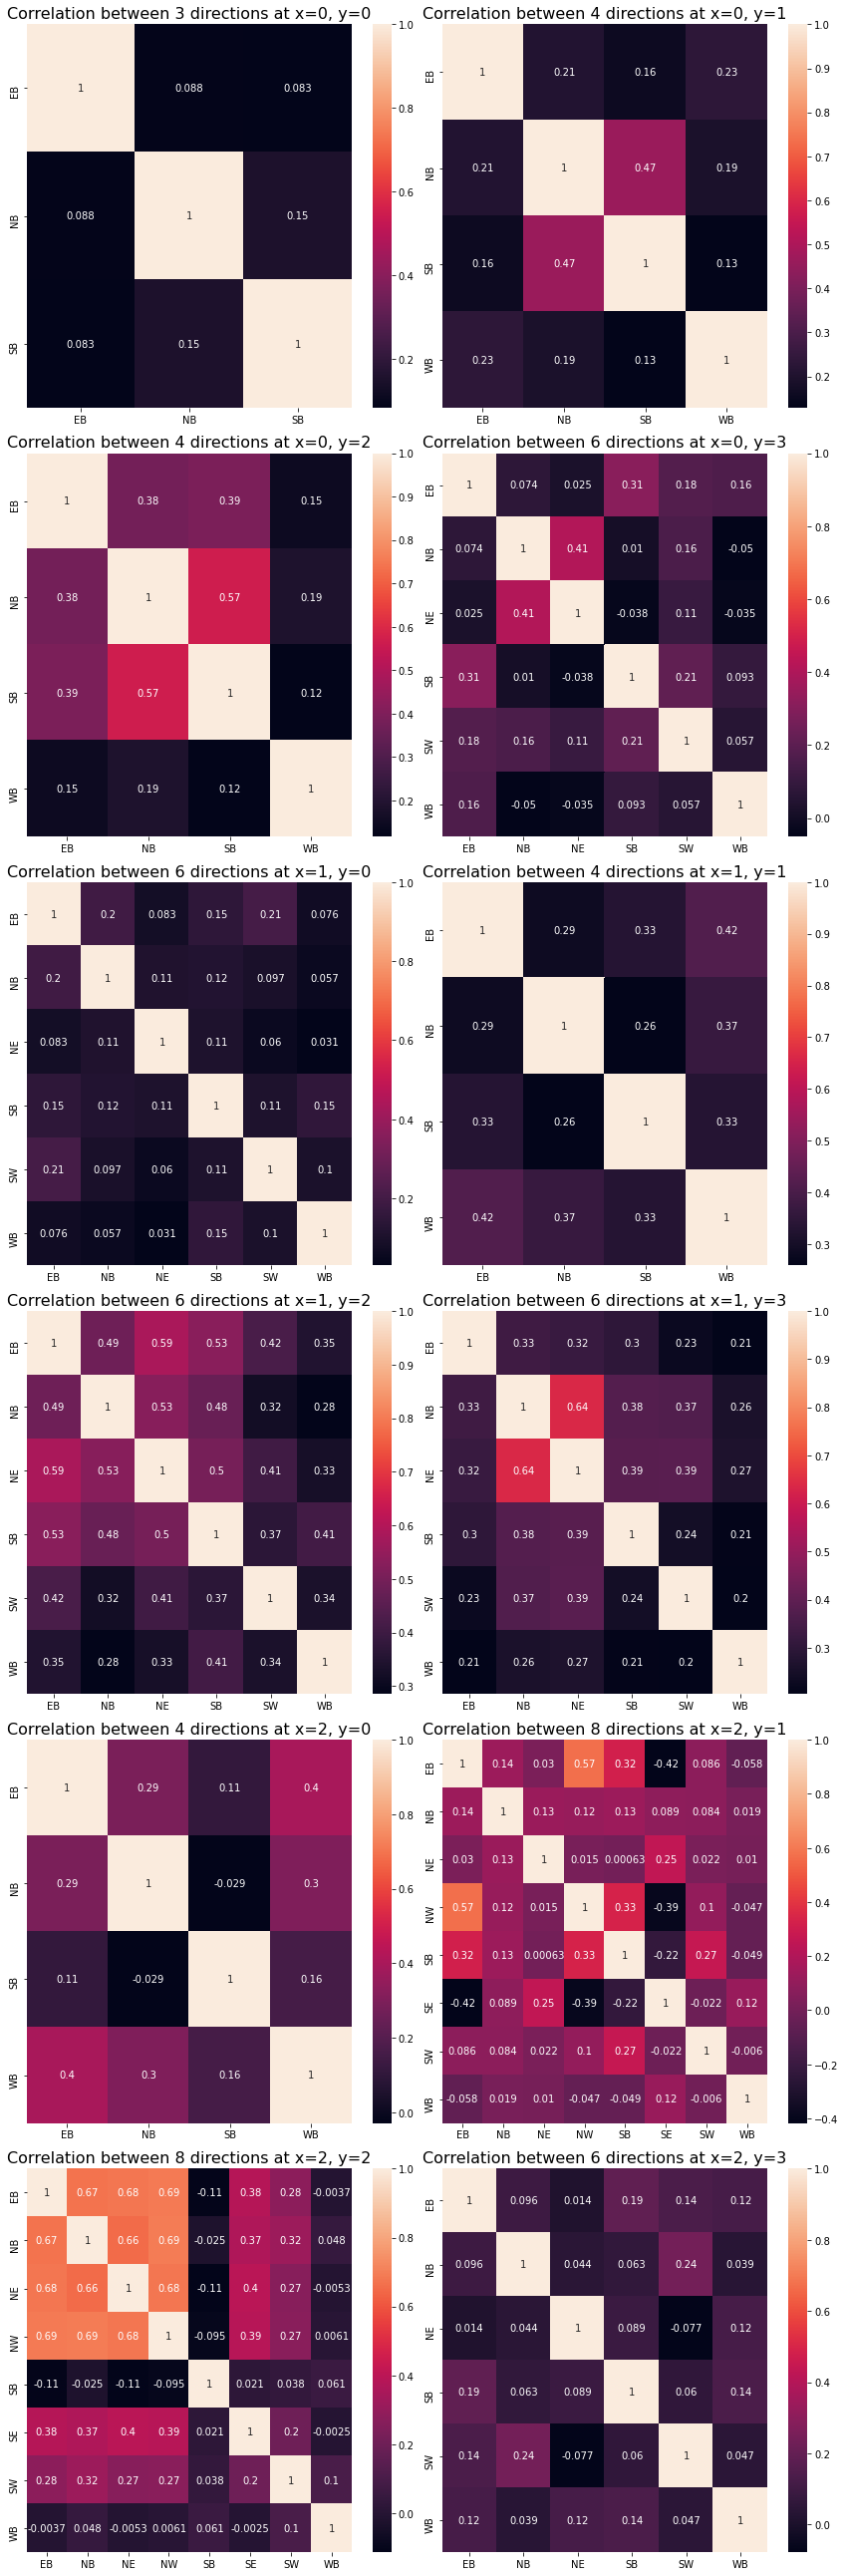

In [22]:
plt.figure(figsize=(12,36))
for x in range(3):
    for y in range(4):
        dfs = []
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                dfs.append(df.congestion.tolist())
                
        roadway_congestions = pd.DataFrame(np.array(dfs).T, columns=train[(train.x == x) & (train.y==y)].direction.unique())
        
        plt.subplot(6,2,4*x+y+1)
        sns.heatmap(roadway_congestions.corr(), annot=True)
        plt.title(f'Correlation between {len(dfs)} directions at x={x}, y={y}', fontsize=16)
        plt.tight_layout()
plt.show()

# <span style='color:#A80808'>Average congestion per month</span>

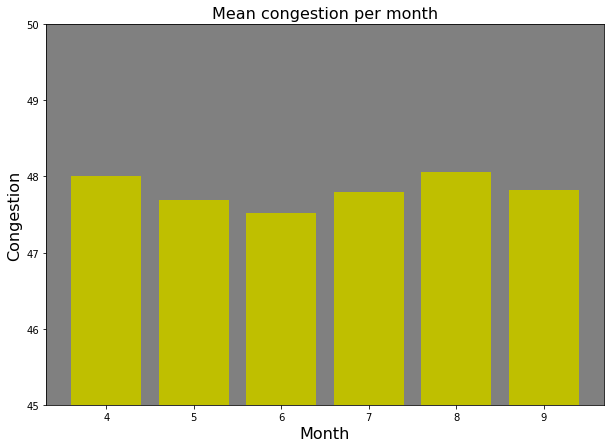

In [23]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.month.unique(), train.groupby(train.time.dt.month).congestion.mean(), color='y')
plt.title(f'Mean congestion per month', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

# <span style='color:#A80808'>Average congestion per month for each roadway</span>

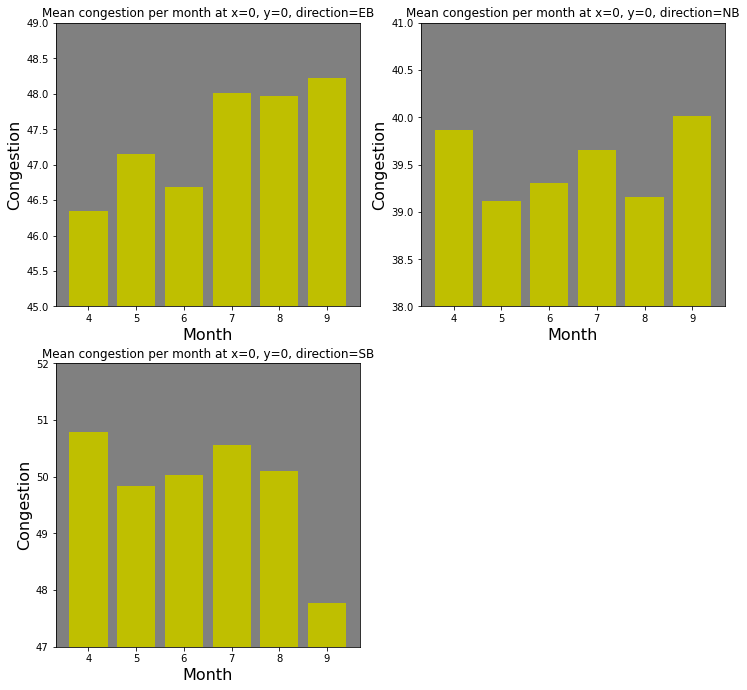

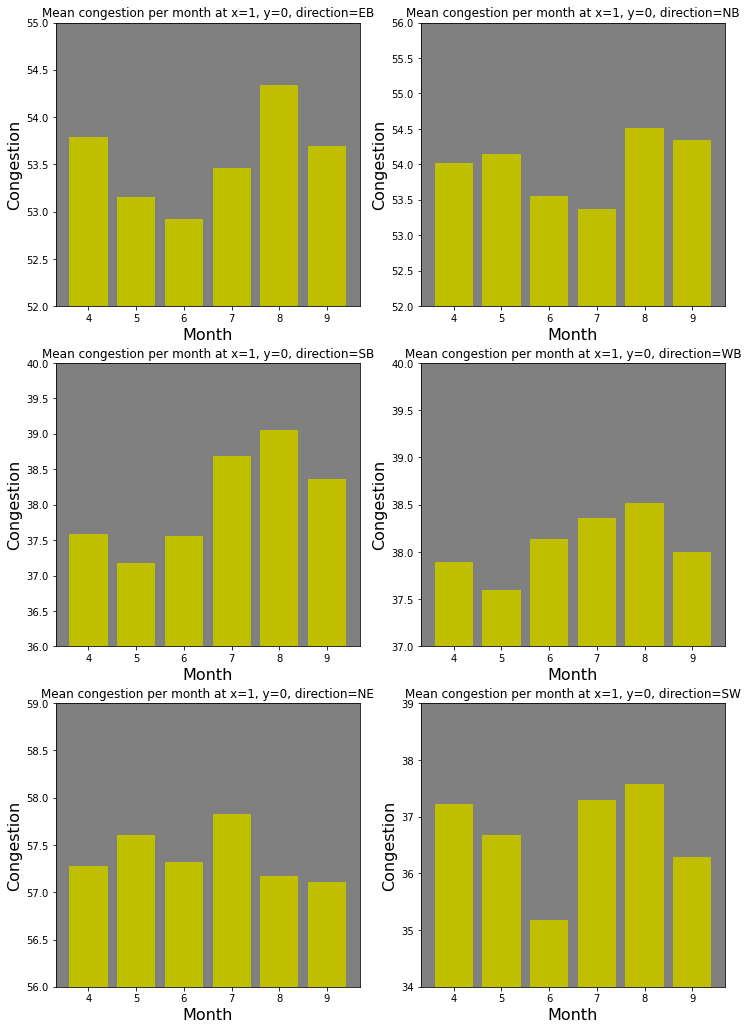

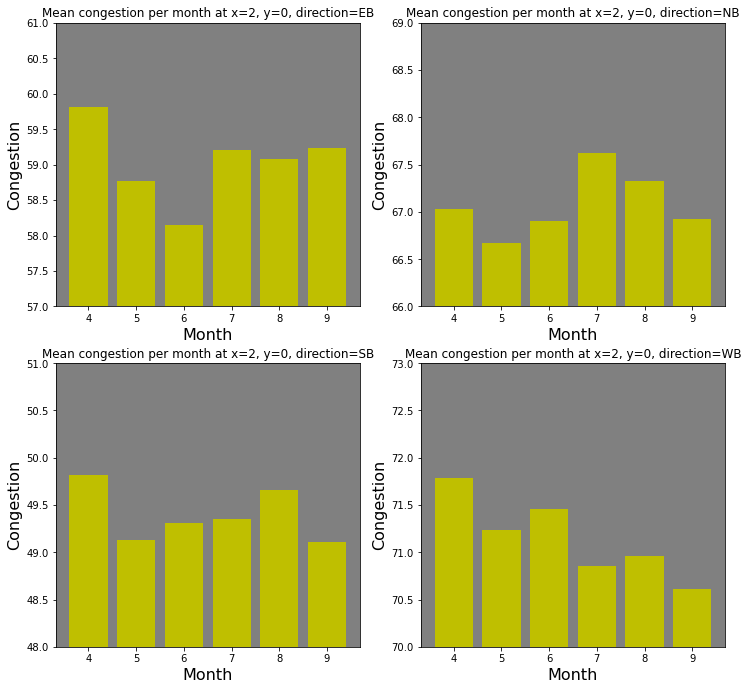

In [24]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.month.unique(), df.groupby(df.time.dt.month).congestion.mean(), color='y')
                plt.title(f'Mean congestion per month at x={x}, y={y}, direction={direction}')
                plt.xlabel('Month', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.month).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.month).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average montly congestion</span>

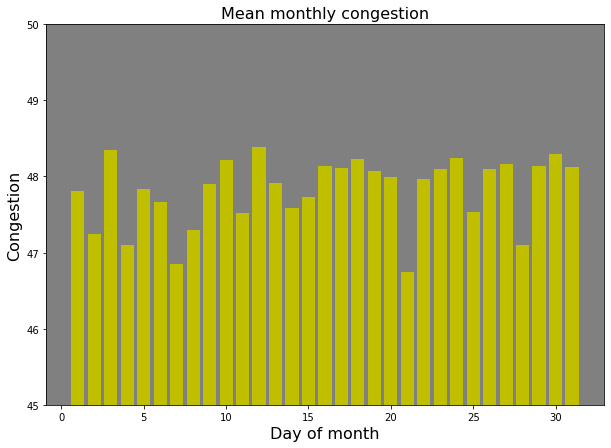

In [25]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.day.unique(), train.groupby(train.time.dt.day).congestion.mean(), color='y')
plt.title(f'Mean monthly congestion', fontsize=16)
plt.xlabel('Day of month', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

# <span style='color:#A80808'>Average montly congestion for each roadway</span>

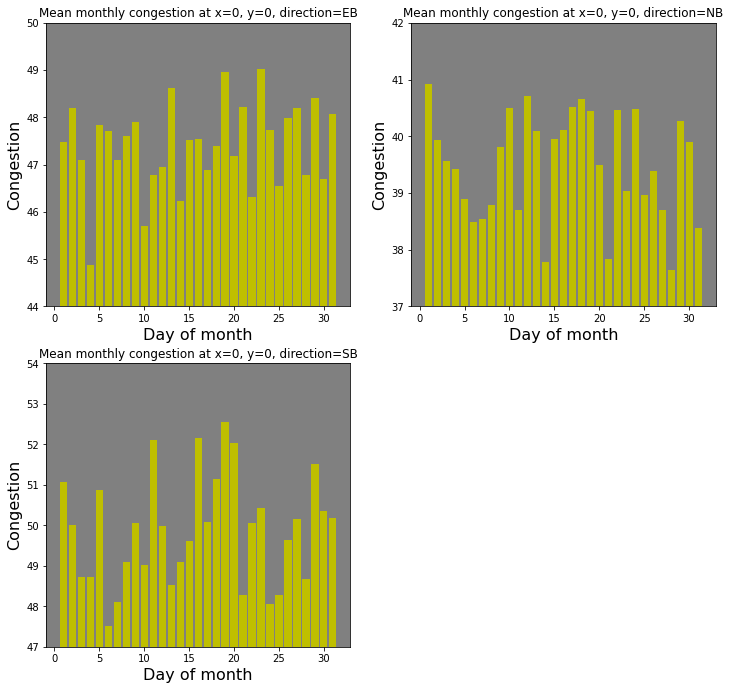

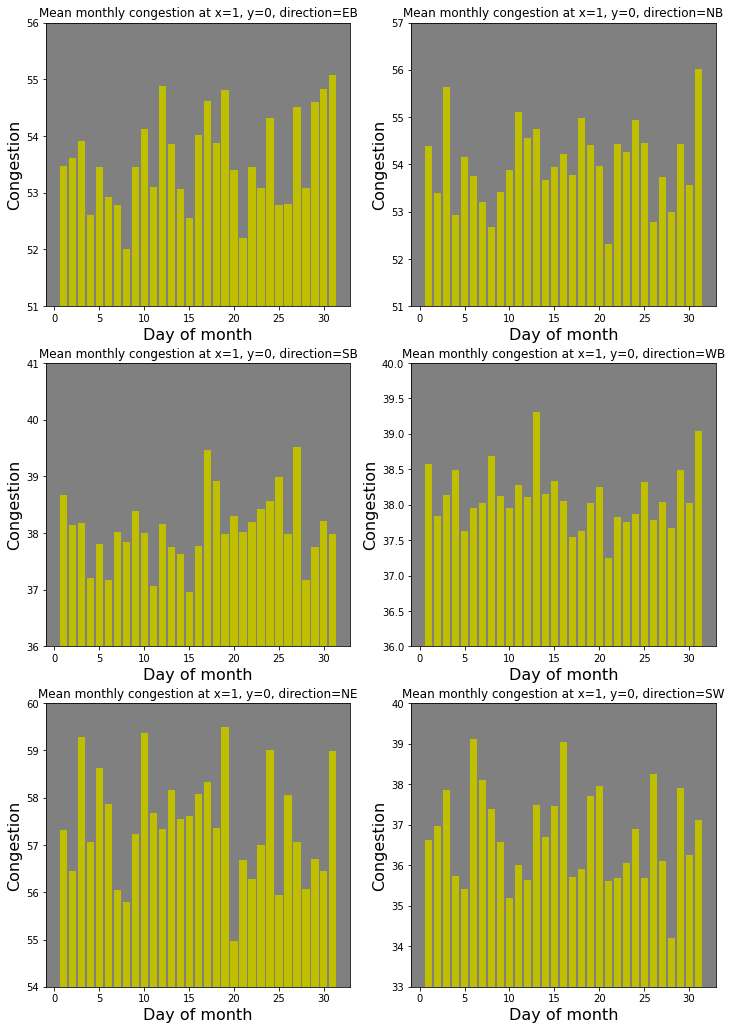

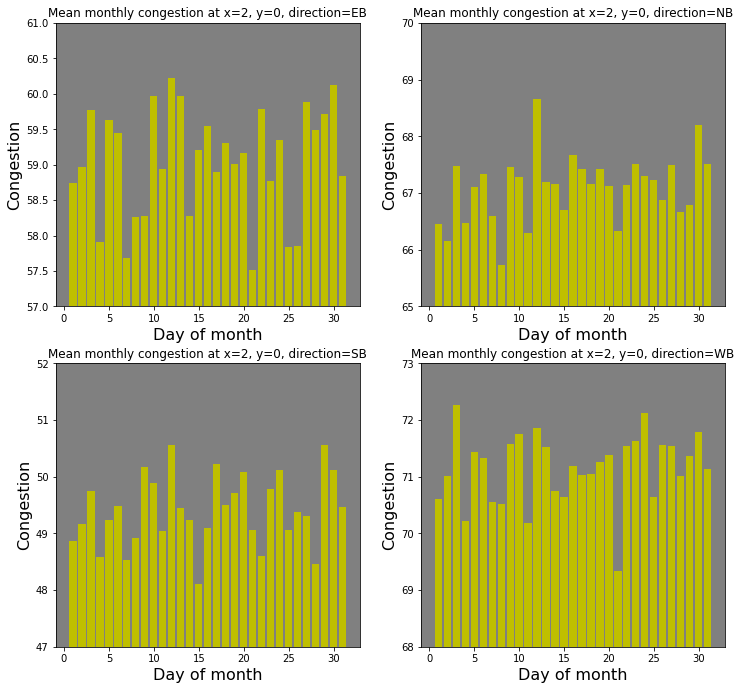

In [26]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.day.unique(), df.groupby(df.time.dt.day).congestion.mean(), color='y')
                plt.title(f'Mean monthly congestion at x={x}, y={y}, direction={direction}')
                plt.xlabel('Day of month', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.day).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.day).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average congestion per week</span>

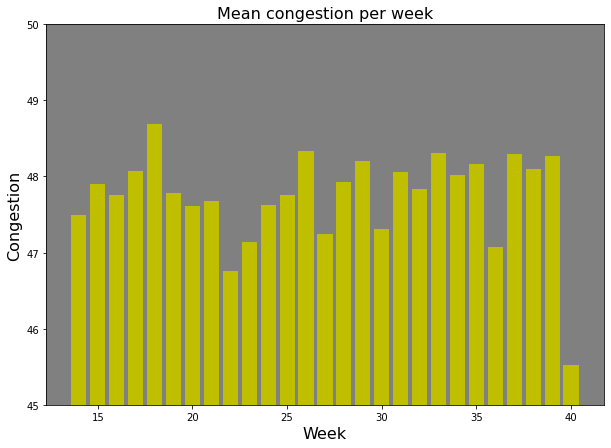

In [27]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.week.unique(), train.groupby(train.time.dt.week).congestion.mean(), color='y')
plt.title(f'Mean congestion per week', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

# <span style='color:#A80808'>Average congestion per week for each roadway</span>

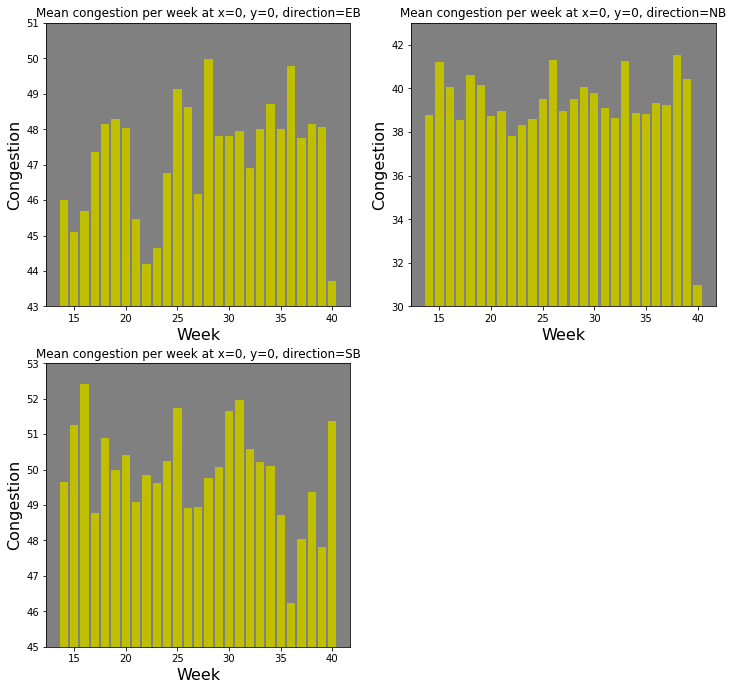

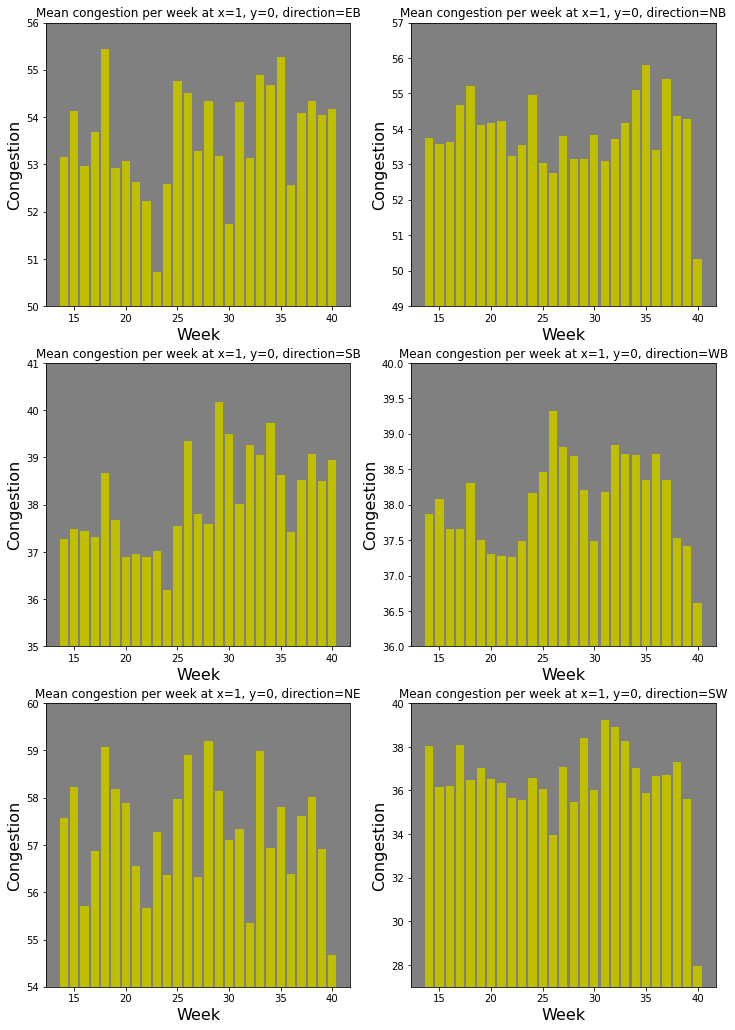

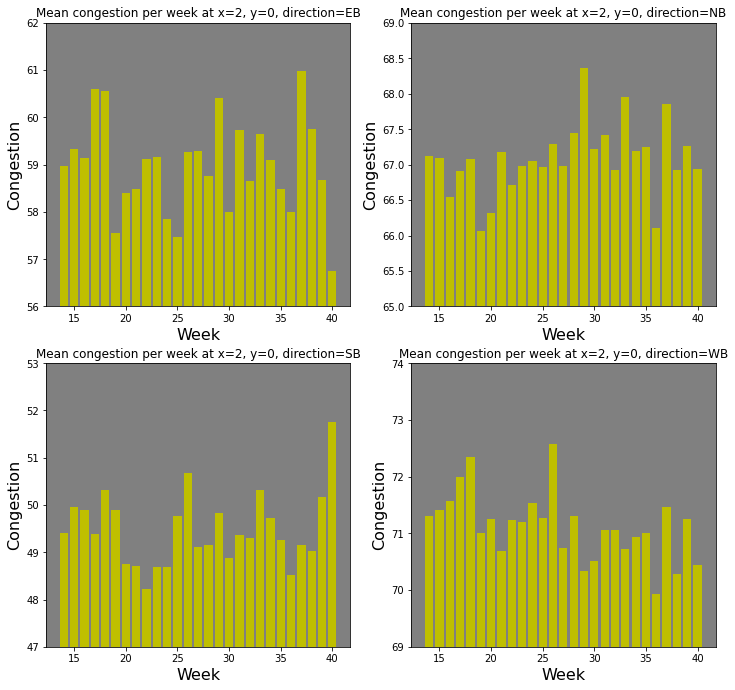

In [28]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.week.unique(), df.groupby(df.time.dt.week).congestion.mean(), color='y')
                plt.title(f'Mean congestion per week at x={x}, y={y}, direction={direction}')
                plt.xlabel('Week', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.week).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.week).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average weekly congestion</span>

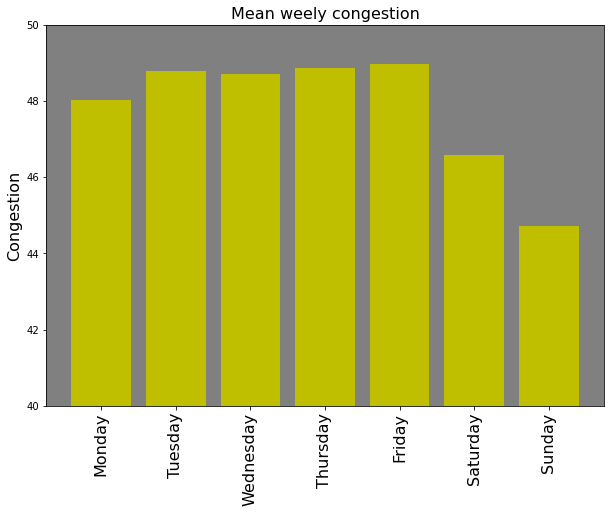

In [29]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.weekday.unique(), train.groupby(train.time.dt.weekday).congestion.mean(), color='y')
plt.title(f'Mean weely congestion', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=16, rotation=90)
plt.ylim(40,50)
plt.show()

# <span style='color:#A80808'>Average weekly congestion for each roadway</span>

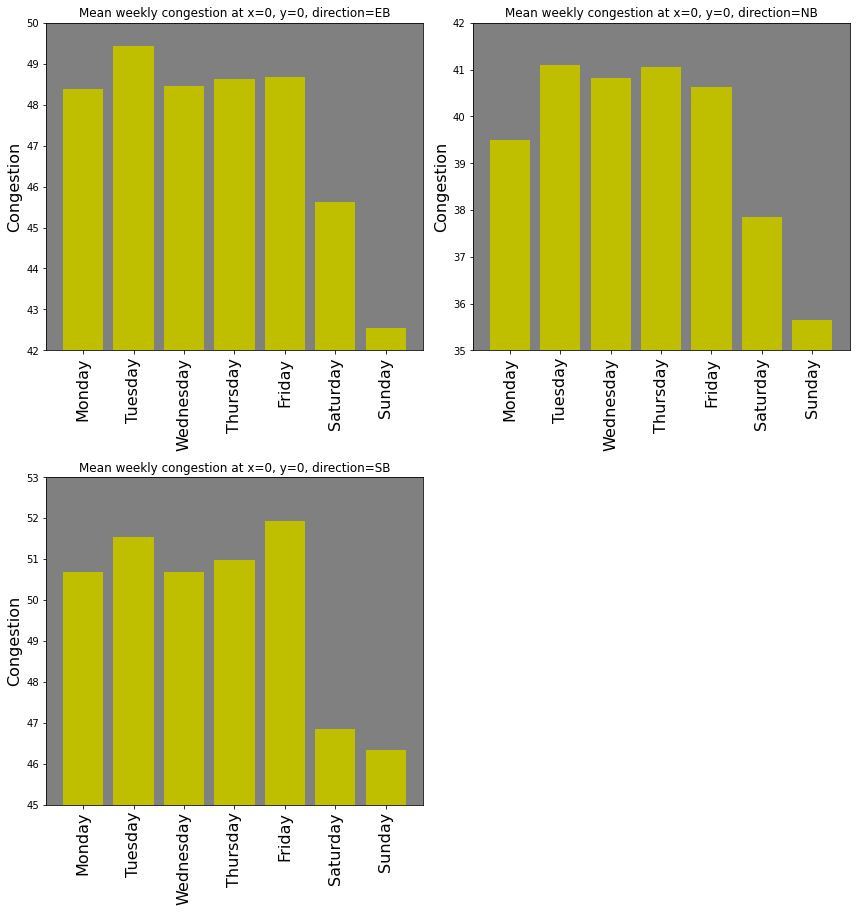

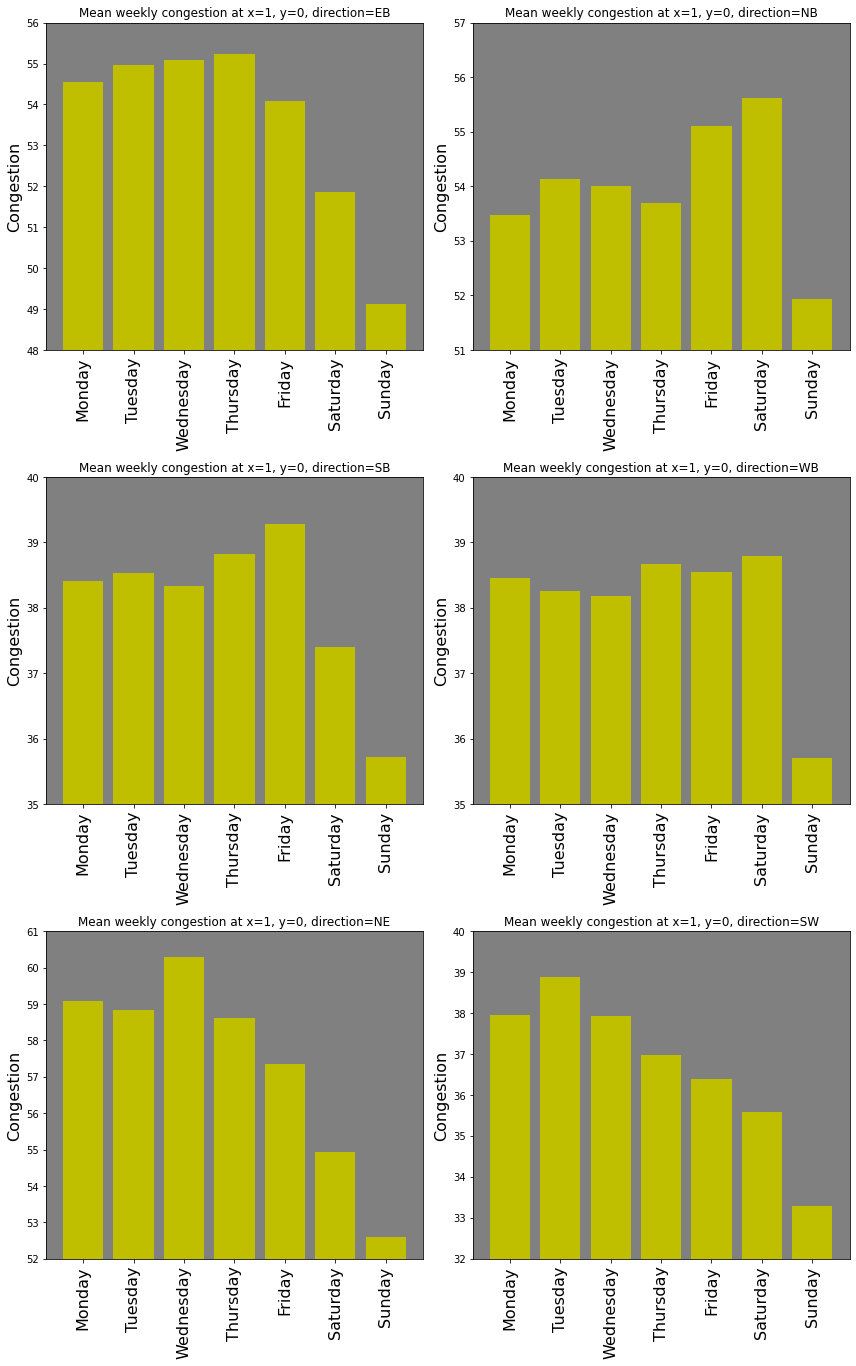

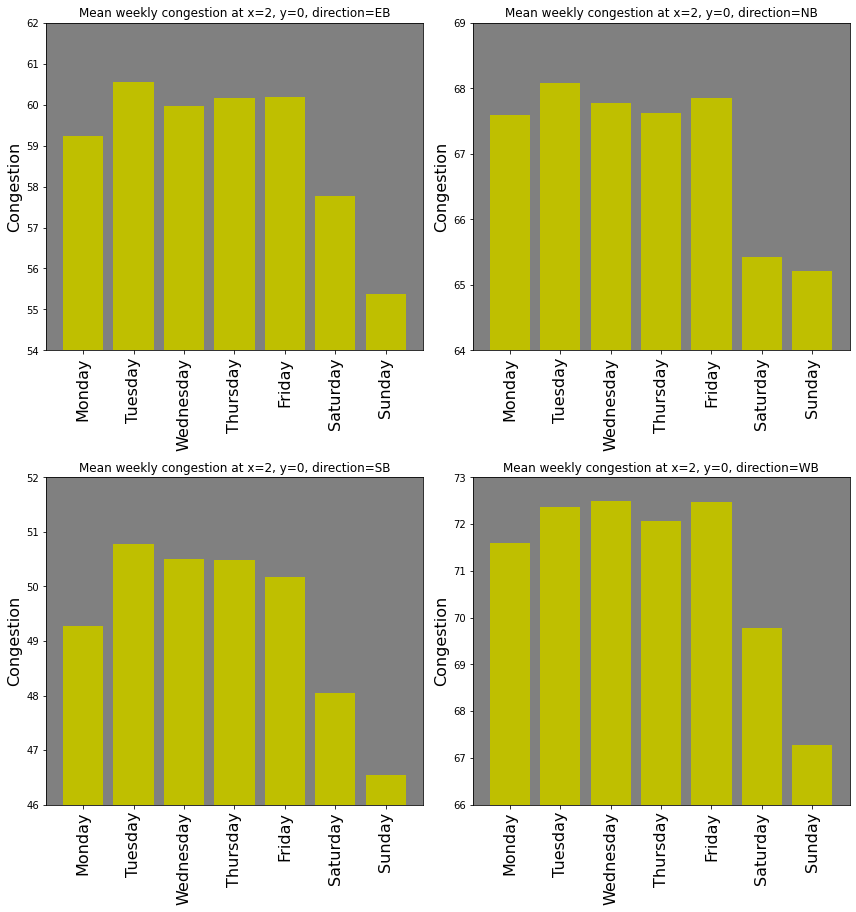

In [30]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.weekday.unique(), df.groupby(df.time.dt.weekday).congestion.mean(), color='y')
                plt.title(f'Mean weekly congestion at x={x}, y={y}, direction={direction}')
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.weekday).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.weekday).congestion.mean().round().astype(int).max()+1)
                plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=16, rotation=90)
                plt.tight_layout()
        plt.show()
                
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average congestion per day</span>

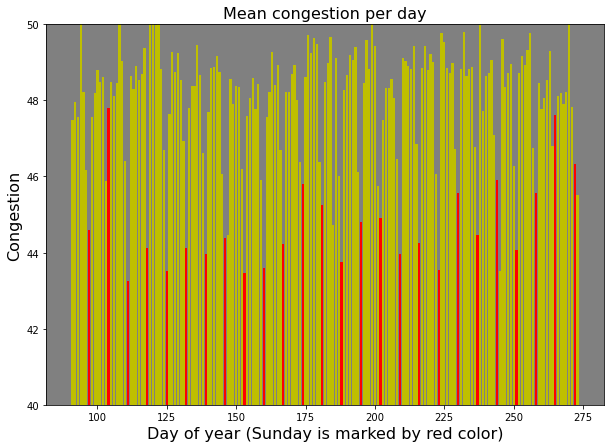

In [31]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.dayofyear.unique(), train.groupby(train.time.dt.dayofyear).congestion.mean(), color=['r' if (int(day)%7)==6 else 'y' for day in train.time.dt.dayofyear.unique()])
plt.title(f'Mean congestion per day', fontsize=16)
plt.xlabel('Day of year (Sunday is marked by red color)', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(40,50)
plt.show()

# <span style='color:#A80808'>Average congestion per day for each roadway</span>

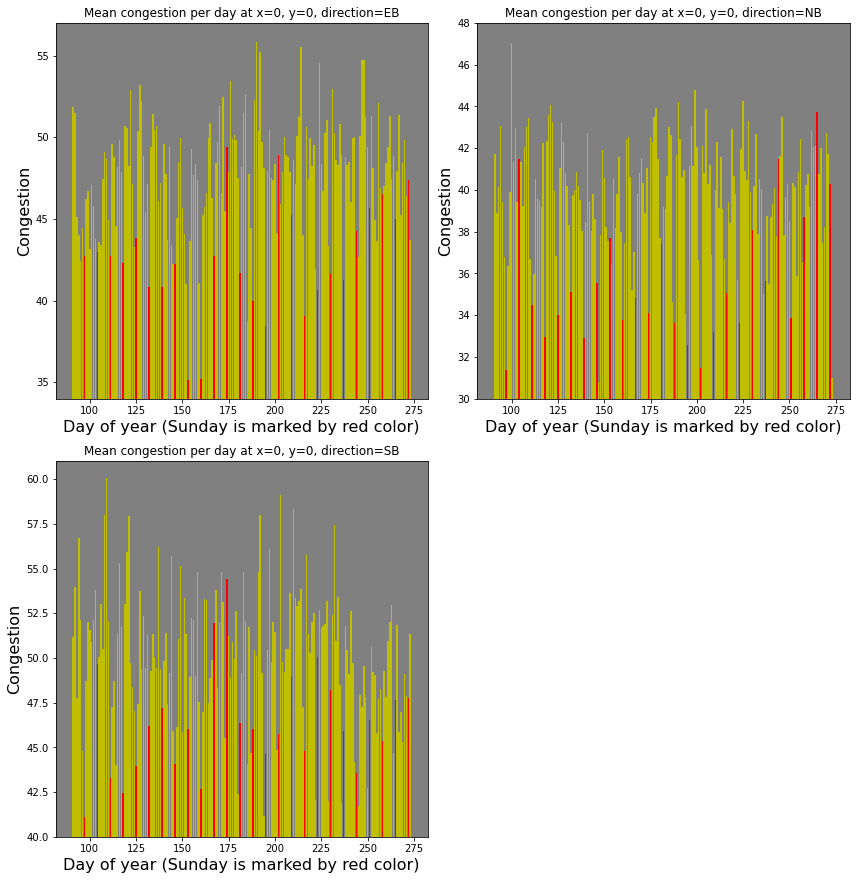

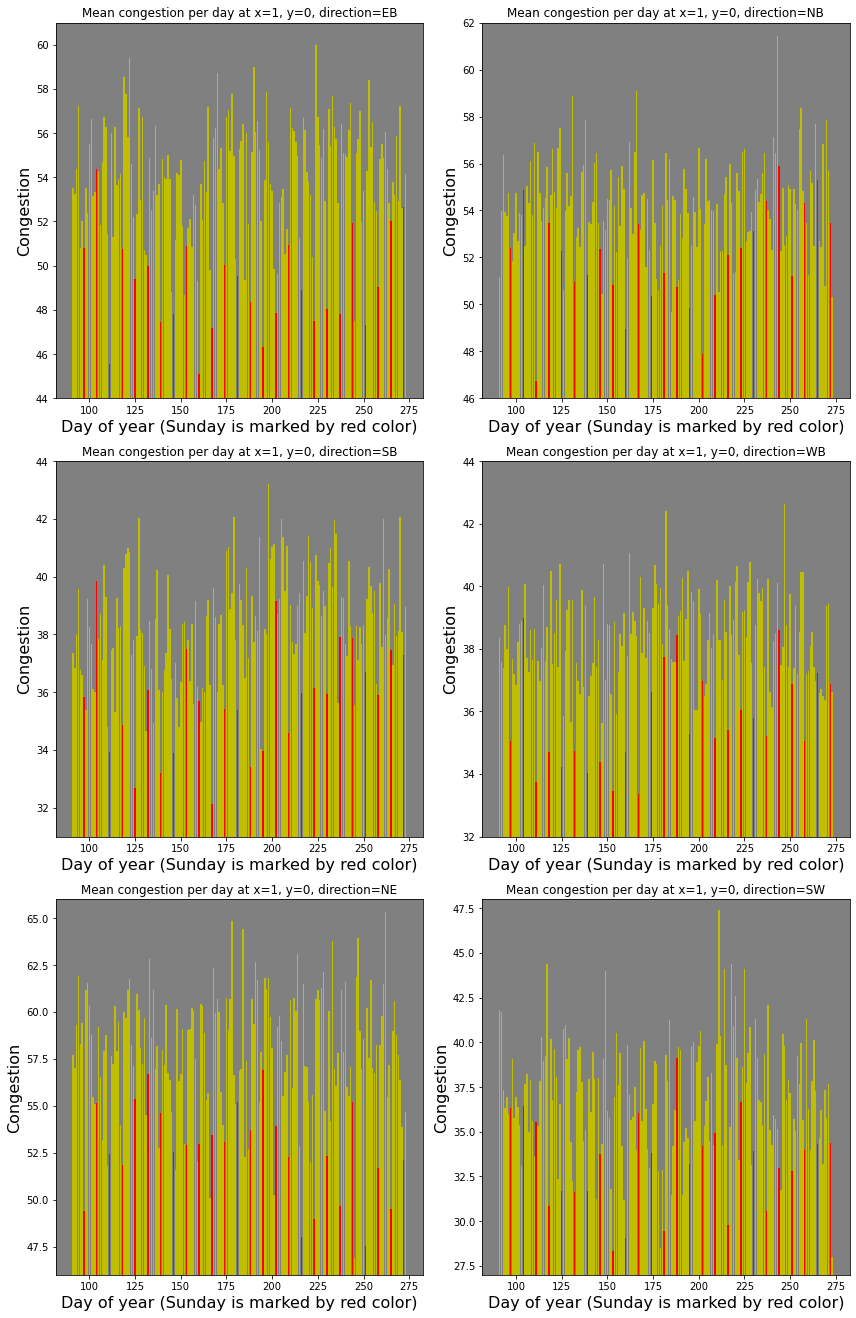

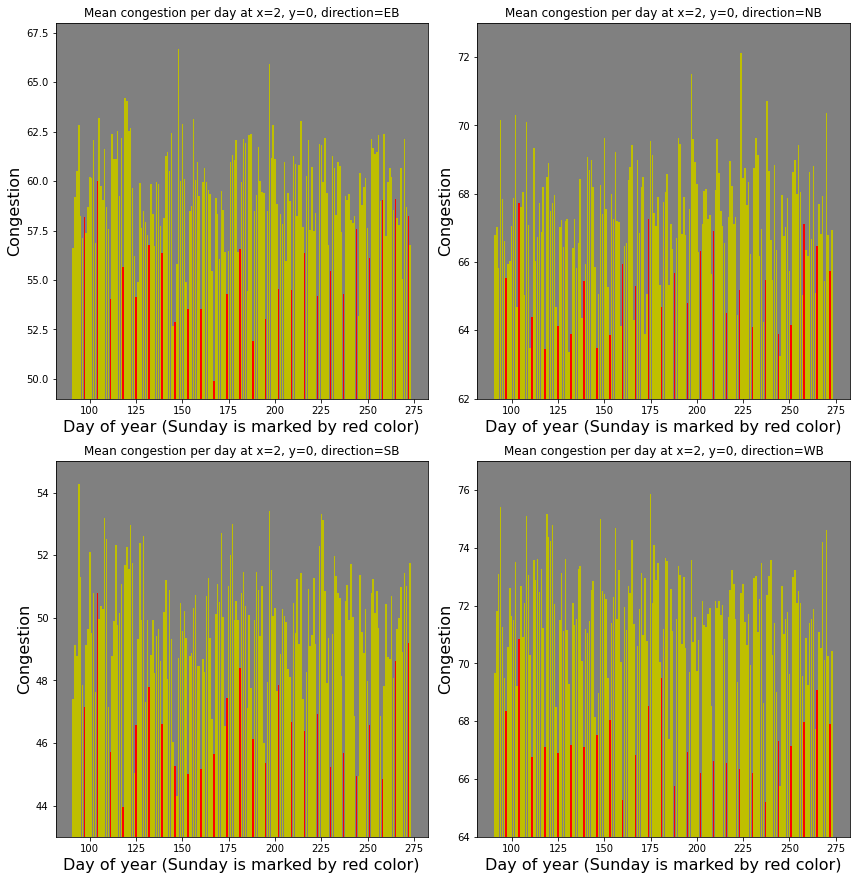

In [32]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.dayofyear.unique(), df.groupby(df.time.dt.dayofyear).congestion.mean(), color=['r' if (int(day)%7)==6 else 'y' for day in train.time.dt.dayofyear.unique()])
                plt.title(f'Mean congestion per day at x={x}, y={y}, direction={direction}')
                plt.xlabel('Day of year (Sunday is marked by red color)', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)                
                plt.ylim(df.groupby(df.time.dt.dayofyear).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.dayofyear).congestion.mean().round().astype(int).max()+1)
                plt.tight_layout()
        plt.show()
                
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average daily congestion</span>

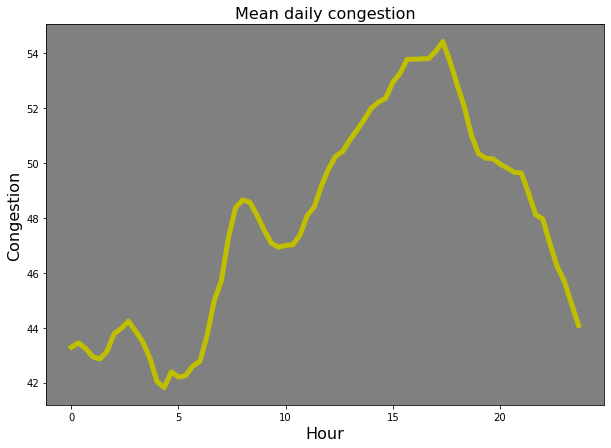

In [33]:
plt.figure(figsize=(10,7))
plt.plot(train.groupby(train.daytime_id).daytime_id.unique()/3.0, train.groupby(train.daytime_id).congestion.mean(), 'y', linewidth=5)
plt.title(f'Mean daily congestion', fontsize=16)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.show()

# <span style='color:#A80808'>Average daily congestion for each roadway</span>

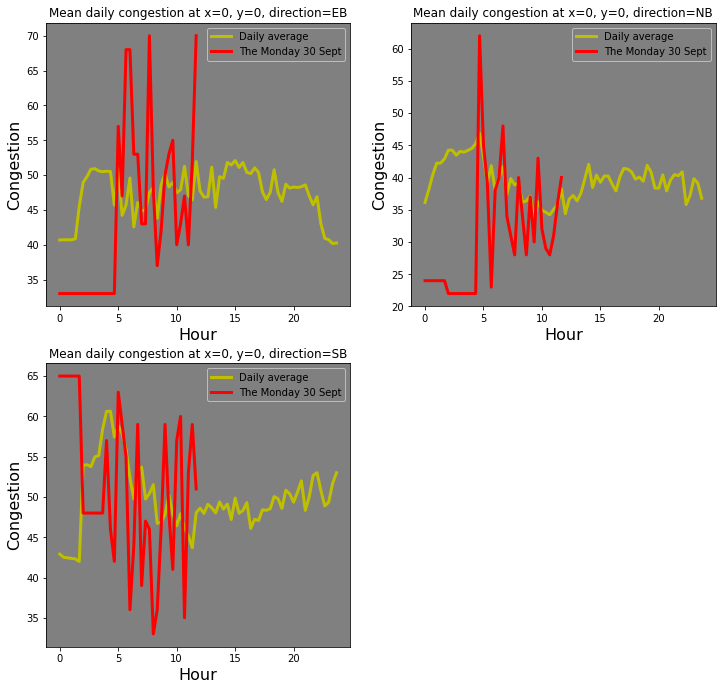

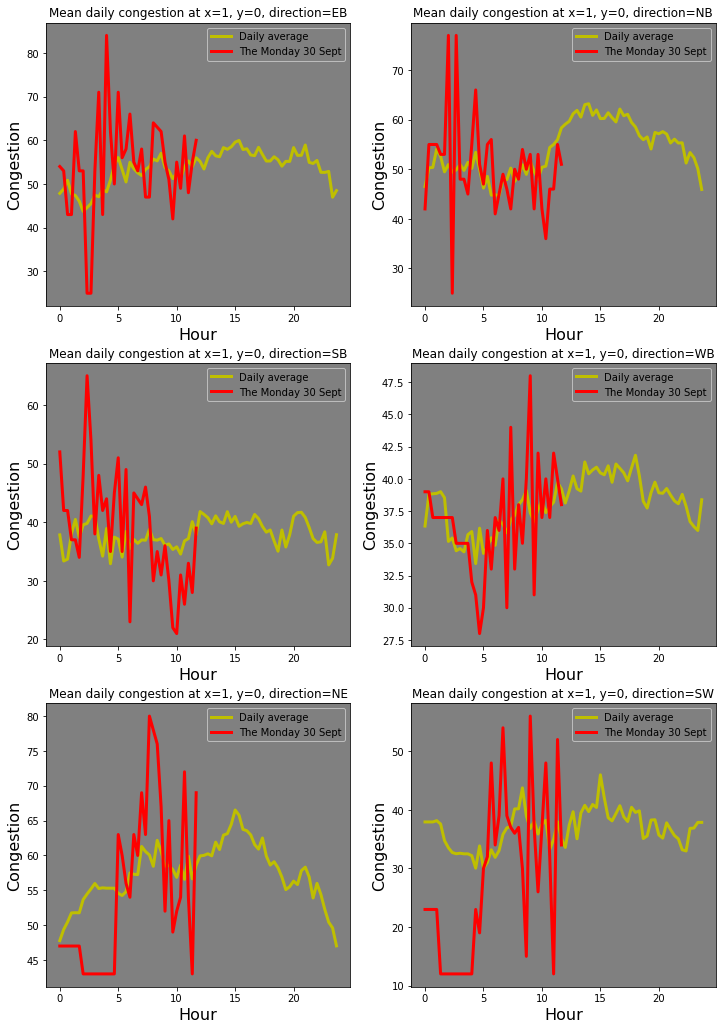

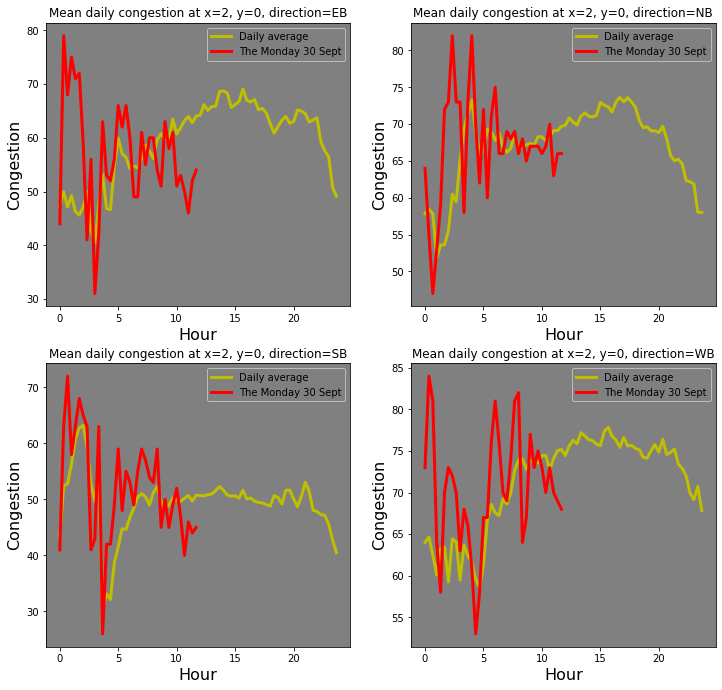

In [34]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.mean(), 'y', linewidth=3, label='Daily average')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'Mean daily congestion at x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Average Monday congestion</span>

As 30 Sept 1991 where locating the test set is a Monday. It is of interest to examine data of this day of week.

In [35]:
df = train[train.time.dt.weekday==0]

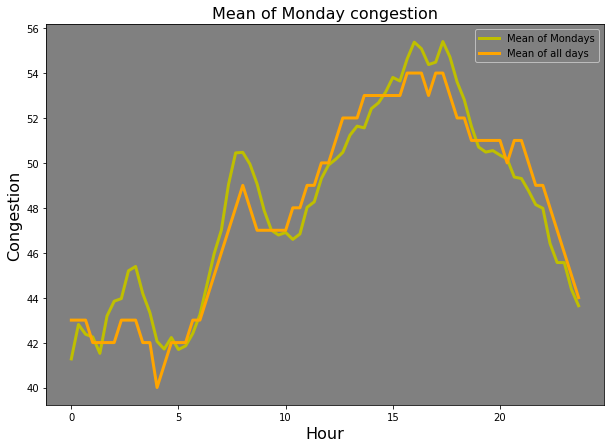

In [36]:
plt.figure(figsize=(10,7))
plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.mean(), 'y', linewidth=3, label='Mean of Mondays')

plt.plot(train.groupby(train.daytime_id).daytime_id.unique()/3.0, train.groupby(train.daytime_id).congestion.median(), 'orange', linewidth=3, label='Mean of all days')
plt.title(f'Mean of Monday congestion', fontsize=16)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.legend()
plt.show()

# <span style='color:#A80808'>Average Monday congestion for each roadway</span>

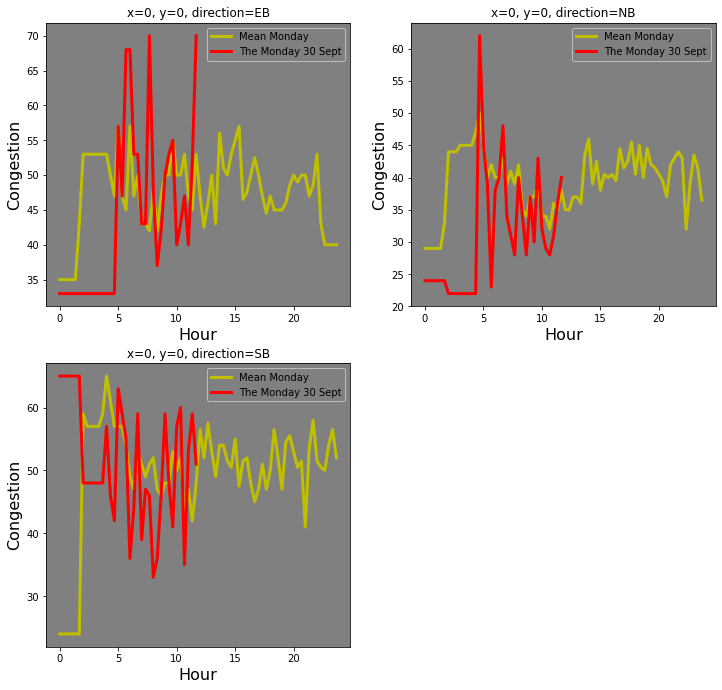

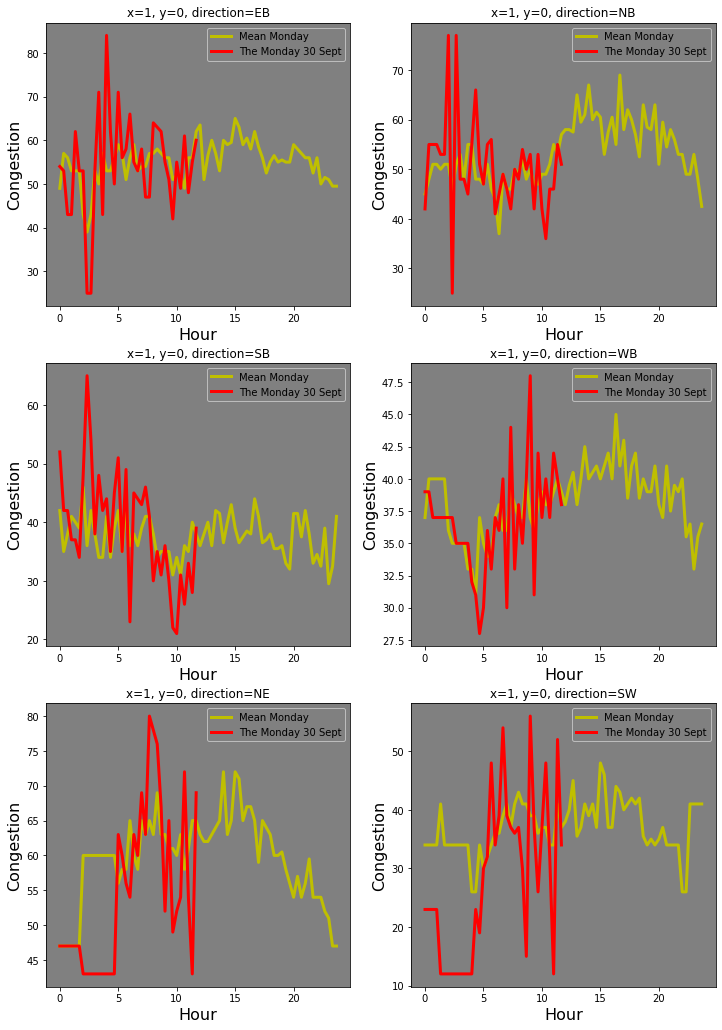

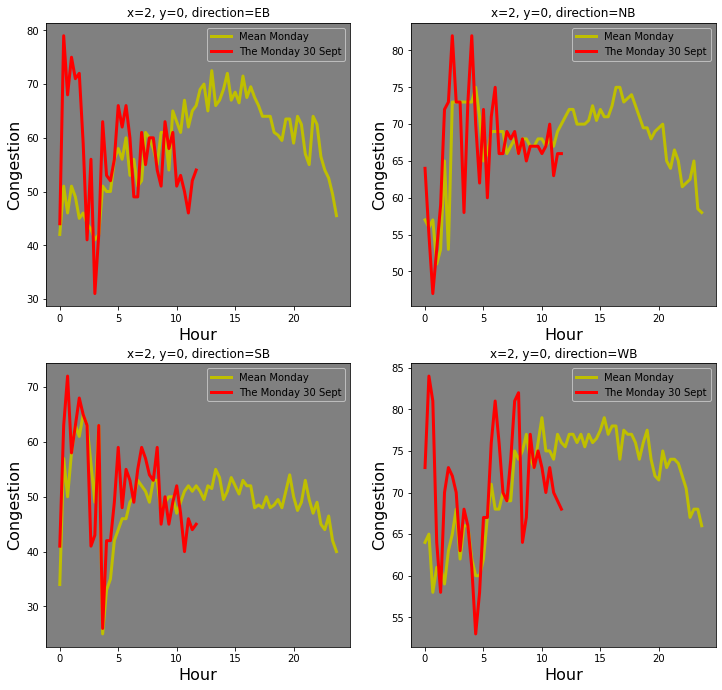

In [37]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.median(), 'y', linewidth=3, label='Mean Monday')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>The nearest Monday 23 Sept</span>

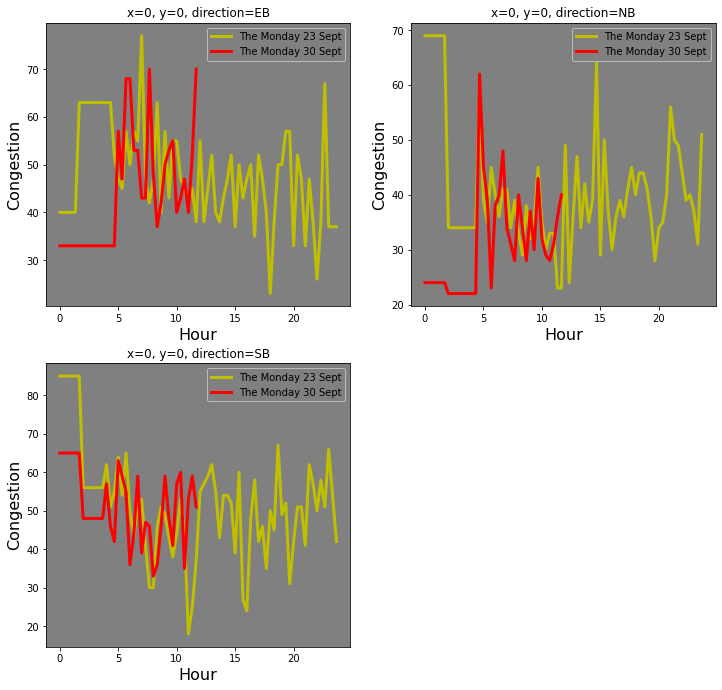

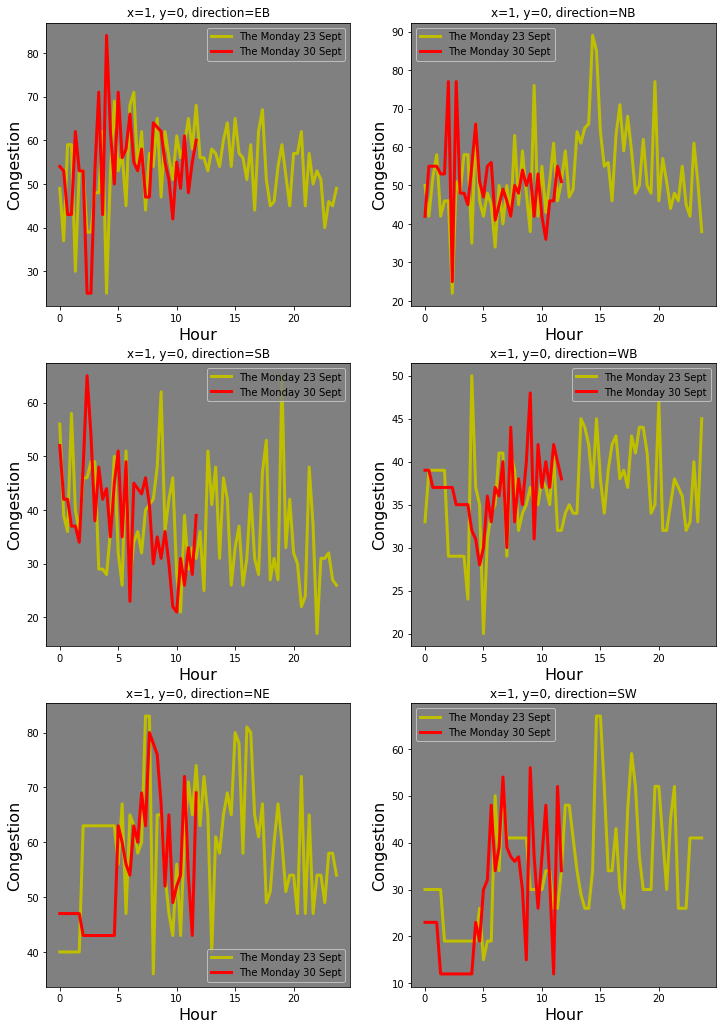

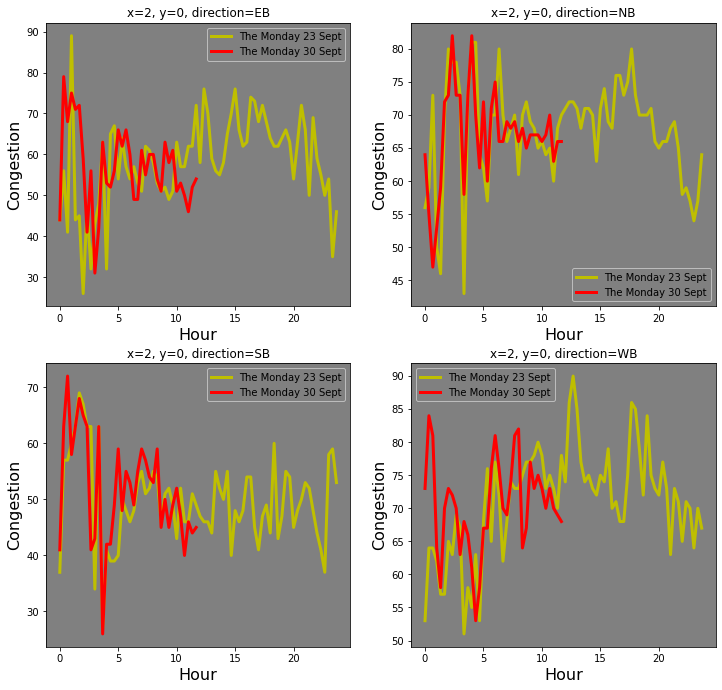

In [38]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df[train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7].daytime_id/3.0, df[train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7].congestion, 'y', linewidth=3, label='The Monday 23 Sept')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remove break to plot for all the 65 roadways

# <span style='color:#A80808'>Correlation between the days</span>

In [39]:
train_new.congestion = train_new.congestion.fillna(train_new.congestion.mean())

In [40]:
congestion = pd.DataFrame(np.array(train_new.congestion).reshape(365,2340).T)
congestion_morning = congestion[[col for col in congestion.columns if col%2==0]]
congestion_afternoon = congestion[[col for col in congestion.columns if col%2==1]]
congestion_monday_afternoon = congestion[[col for col in congestion.columns if col%14==1]].round().astype(int)
congestion_monday_afternoon_smoothed = congestion_monday_afternoon.rolling(10, min_periods=1).mean()

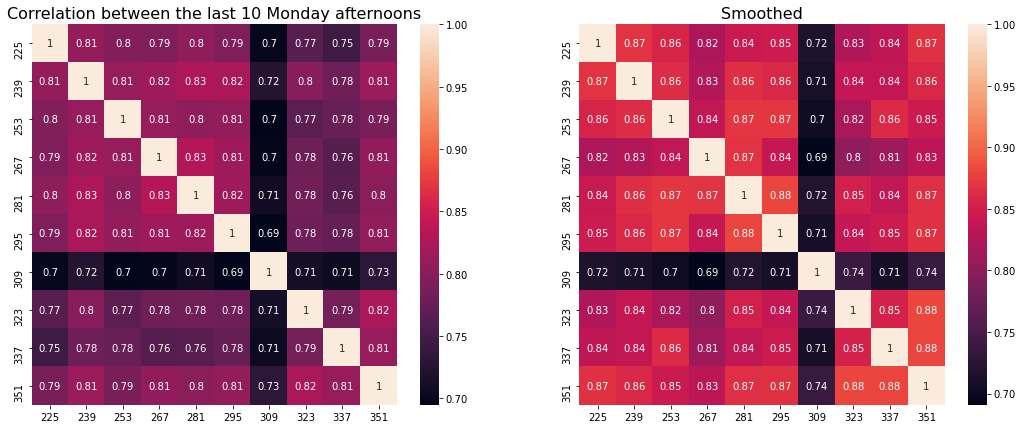

In [41]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
sns.heatmap(congestion_monday_afternoon[congestion_monday_afternoon.columns[-10:]].corr(), annot=True)
plt.title('Correlation between the last 10 Monday afternoons', fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(congestion_monday_afternoon_smoothed[congestion_monday_afternoon_smoothed.columns[-10:]].corr(), annot=True)
plt.title('Smoothed', fontsize=16)

plt.show()

# <span style='color:#A80808'>Score between the congestion of the Monday afternoons</span>

Below I compute the mean absolute error between all the Monday afternoons and the nearest Monday afternoon of the test (the 23 Sept)

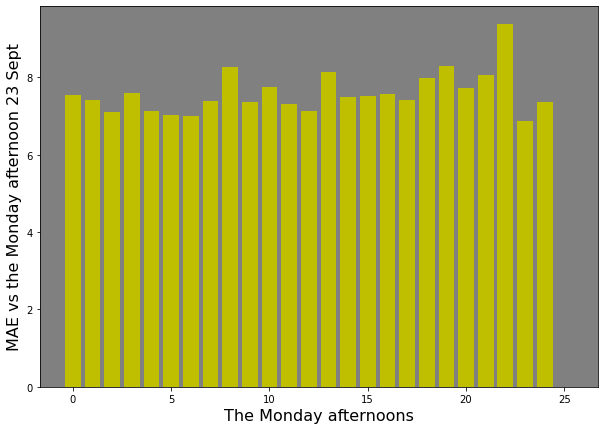

In [42]:
df = congestion_monday_afternoon
scores=[]
for idx in df.columns:
    score = 0
    for time_id in range(36):
        score +=mean_absolute_error(df[idx][(time_id*65):((time_id+1)*65)].astype(int), df[df.columns[-1]][(time_id*65):((time_id+1)*65)].astype(int))
    scores.append(score/36.0)

plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The Monday afternoons', fontsize=16)
plt.ylabel('MAE vs the Monday afternoon 23 Sept', fontsize=16)
plt.show()

# <span style='color:#A80808'>Score between the congestion of the Monday afternoons w.r.t. the median congestion</span>

The mean absolute error between all the Monday afternoons and the median congestion over all the afternoons is shown below.

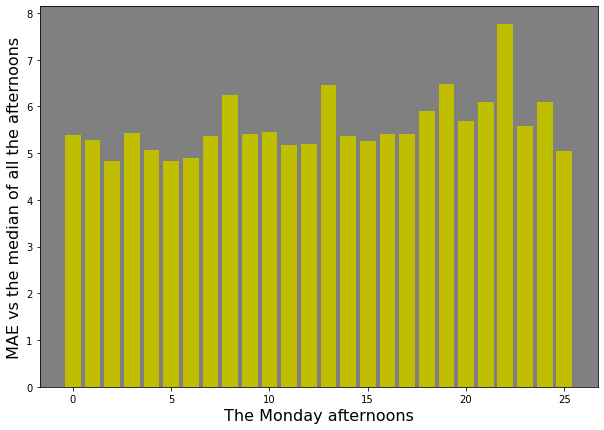

In [43]:
df = congestion_afternoon
df_monday = congestion_monday_afternoon
scores=[]
for idx in df_monday.columns:
    score =mean_absolute_error(df_monday[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The Monday afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

# <span style='color:#A80808'>Score between the congestion of the afternoons</span>

The mean absolute error between all the afternoons and the nearest afternoon of the test (the 29 Sept) is shown below.

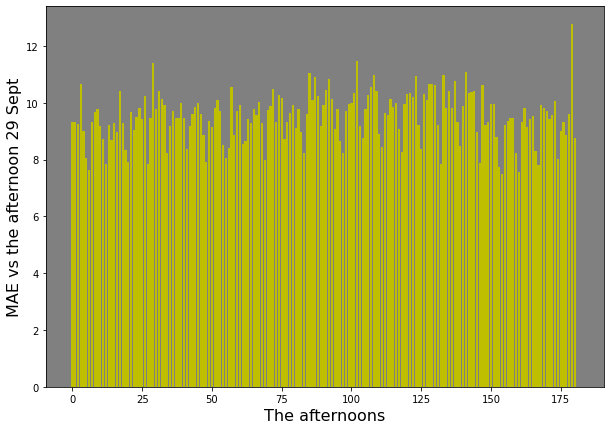

In [44]:
df = congestion_afternoon
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), df[df.columns[-1]].astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the afternoon 29 Sept', fontsize=16)
plt.show()

# <span style='color:#A80808'>Score between the congestion of the afternoons w.r.t. the median congestion</span>

The mean absolute error between all the afternoons and the median congestion over all the afternoons is shown below.

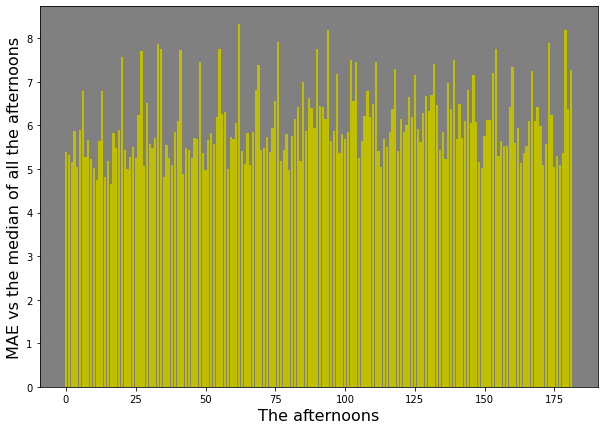

In [45]:
df = congestion_afternoon
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

# <span style='color:#A80808'>The ouliers</span>

We may consider the afternoons with high MAE w.r.t. the median congestion as outliers.

In [46]:
df = congestion_afternoon
outliers=[]
outlier_days=[]
for idx in df.columns:
    if (mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int)) > 7):
        day_idx = idx //2 + 91
        
        outliers.append(idx)
        outlier_days.append(day_idx)
print(f'% outliers: {len(outliers)/len(df.columns)*100}')

% outliers: 15.934065934065933


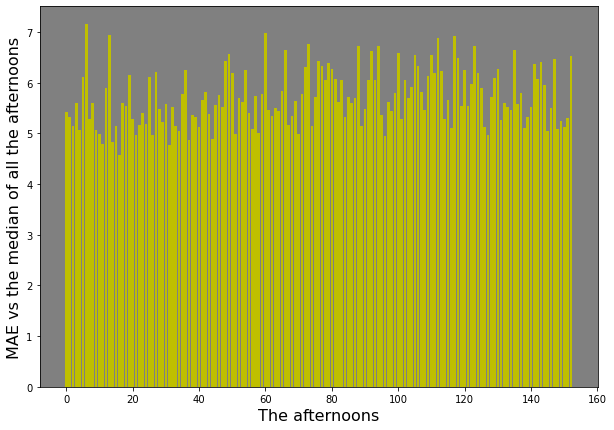

In [47]:
df = congestion_afternoon[[idx for idx in congestion_afternoon.columns if idx not in outliers]]
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

# <span style='color:#A80808'>Simple baselines without Machine Learning</span>

## Daily average

In [48]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [49]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/dailyMedian.csv', index=False)
submission.head()

,row_id,congestion
0,848835,47
1,848836,34
2,848837,50
3,848838,26
4,848839,71


## Daily average, exclude weekend

In [50]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df[df.time.dt.weekday<=4].groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [51]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/dailyMedianExcludeWeekend.csv', index=False)
submission.head()

,row_id,congestion
0,848835,50
1,848836,35
2,848837,54
3,848838,26
4,848839,72


## Daily average, remove outliers

In [52]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction) & (~train.time.dt.dayofyear.isin(outlier_days))]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [53]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/dailyMedianRemoveOutliers.csv', index=False)
submission.head()

,row_id,congestion
0,848835,48
1,848836,35
2,848837,52
3,848838,27
4,848839,72


## Average of all Monday

The baseline below simply takes, for each roadway, the average of the Monday afternoon congestion as a prediction for the Monday afternoon 30 Sept (see the [discussion](https://www.kaggle.com/c/tabular-playground-series-mar-2022/discussion/310642)).

In [54]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.mean().tolist()[-36:]

In [55]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/MondayMean.csv', index=False)
submission.head()

,row_id,congestion
0,848835,46
1,848836,36
2,848837,55
3,848838,22
4,848839,72


## The nearest Monday

We can observe that the nearest Monday (23 Sept) fits better with the Monday 30 Sept comparing to the mean over all the Monday. Therefore, we could also consider this day as a baseline. We consider also a window average (rolling) to reduce the variance of the prediction.

In [56]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.congestion.rolling(10).mean()[-36:].tolist()

In [57]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/23SeptSmooth.csv', index=False)
submission.head()

,row_id,congestion
0,848835,48
1,848836,34
2,848837,41
3,848838,26
4,848839,64


## Daily Linear Regression

In [58]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train_new[(train_new.x == x) & (train_new.y==y) & (train_new.direction==direction)]
            df_new = pd.DataFrame()
            if df.shape[0]>0:                
                for idx, group in df.groupby(df.time.dt.dayofyear):
                    if len(group.congestion) == 72: # consider only days without missing data
                        df_new[f'day_{idx}'] = group.congestion.tolist()
            
                X_train = df_new[df_new.columns[:-1]][-36:]
                y_train = df_new[df_new.columns[-1]][-36:]

                X_test = df_new[df_new.columns[1:]][-36:]

                model = lr()
                model.fit(X_train, y_train)

                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = model.predict(X_test).tolist()

In [59]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/DailyLinearRegression.csv', index=False)
submission.head()

,row_id,congestion
0,848835,46
1,848836,41
2,848837,50
3,848838,19
4,848839,66


Daily Extra Trees

In [60]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train_new[(train_new.x == x) & (train_new.y==y) & (train_new.direction==direction)]
            df_new = pd.DataFrame()
            if df.shape[0]>0:                
                for idx, group in df.groupby(df.time.dt.dayofyear):
                    if len(group.congestion) == 72: # consider only days without missing data
                        df_new[f'day_{idx}'] = group.congestion.tolist()
            
                X_train = df_new[df_new.columns[:-1]][-36:]
                y_train = df_new[df_new.columns[-1]][-36:]

                X_test = df_new[df_new.columns[1:]][-36:]

                model = etr()
                model.fit(X_train, y_train)

                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = model.predict(X_test).tolist()

In [61]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('Submissions/DailyExtraTrees.csv', index=False)
submission.head()

,row_id,congestion
0,848835,41
1,848836,43
2,848837,50
3,848838,20
4,848839,63
